In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

In [2]:
# Calculate means in 30 equal sections for each column
def calculate_means(df):
    columns_to_calculate = ['1', '2', 'Gyroscope [rad/s]']
    means = []

    for column in columns_to_calculate:
        df[f'{column}_copy'] = pd.cut(df.index, bins=30, labels=False)
        column_means = df.groupby(f'{column}_copy')[column].mean().tolist()
        means.extend(column_means)

    return means

# Function to transform data for each trick
def transform(trick_name, trick_folder_path):
    data = []
    for subdir, _, files in os.walk(trick_folder_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file_path.endswith('.csv'):  # Process only CSV files
                df = pd.read_csv(file_path)

                # Calculate means (smoothing and noise reduction)
                means = calculate_means(df)
                means.insert(0, trick_name)  # Insert the trick name into the beginning of the means list

                # Add means
                data.append(means)

    return data

# Function to process tricks in the master folder
def process_master_folder(master_folder_path):
    data = []
    for trick_folder in os.listdir(master_folder_path):
        trick_folder_path = os.path.join(master_folder_path, trick_folder)
        if os.path.isdir(trick_folder_path):
            trick_data = transform(trick_folder, trick_folder_path)
            data.extend(trick_data)
    return data

def plot_data(features_df, plot_individual=True):
    plt.figure(figsize=(20, 10))  # Set the size of the figure here (width, height)
    
    # Define color map for tricks
    color_map = {
        'backflips': 'blue',
        '360_R': 'red',
        '360_L': 'green',
        'frontflips': 'orange'
        # Add more trick names and respective colors...
    }

    if plot_individual:
        for index, row in features_df.iterrows():
            trick_name = row['trick_name']
            values = row.drop('trick_name').astype(float)
            color = color_map.get(trick_name, 'black')  # Assign black if color not found
            
            plt.plot(values, label=f'Trick: {trick_name}', color=color)

        plt.title('Gyroscope Data for Each Trick')
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Value')
        
        
    else:
        # Grouping by trick_name and calculating mean for each category
        grouped_data = features_df.groupby('trick_name').mean()

        for trick_name, values in grouped_data.iterrows():
            color = color_map.get(trick_name, 'black')  # Assign black if color not found

            plt.plot(values, label=f'Trick: {trick_name}', color=color)

        plt.title('Mean Gyroscope Data for Tricks')
        plt.ylabel('Mean Feature Value')
        plt.xlabel('Feature Index')

    # Customize the plot
    plt.xlabel('Feature Index')
    custom_legend = [
            plt.Line2D([0], [0], color='blue', linestyle='-', markersize=8, label='backflips'),
            plt.Line2D([0], [0], color='red', linestyle='-', markersize=8, label='360_R'),
            plt.Line2D([0], [0], color='green', linestyle='-', markersize=8, label='360_L'),
            plt.Line2D([0], [0], color='orange', linestyle='-', markersize=8, label='frontflips')
            ]
    plt.legend(handles=custom_legend)
    plt.xticks(rotation=60)
    
    if plot_individual:
        plt.savefig("Plot_individual.jpg")
    else:
        plt.savefig("Plot_mean.jpg")

    plt.show()
    
def unzip_file(zip_file_name, extract_dir):
    # Check if the extraction directory exists, if not, create it
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    zip_file_path = zip_file_name + '.zip'  # Assuming the zip file is in the same directory as the script
    if not os.path.isfile(zip_file_path):
        print(f"File '{zip_file_path}' not found.")
        return
    
    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"Extraction of '{zip_file_name}.zip' complete in '{extract_dir}'.")


Extraction of 'GoPro_Data.zip' complete in '/Users/ishaan/Desktop/353_Project'.


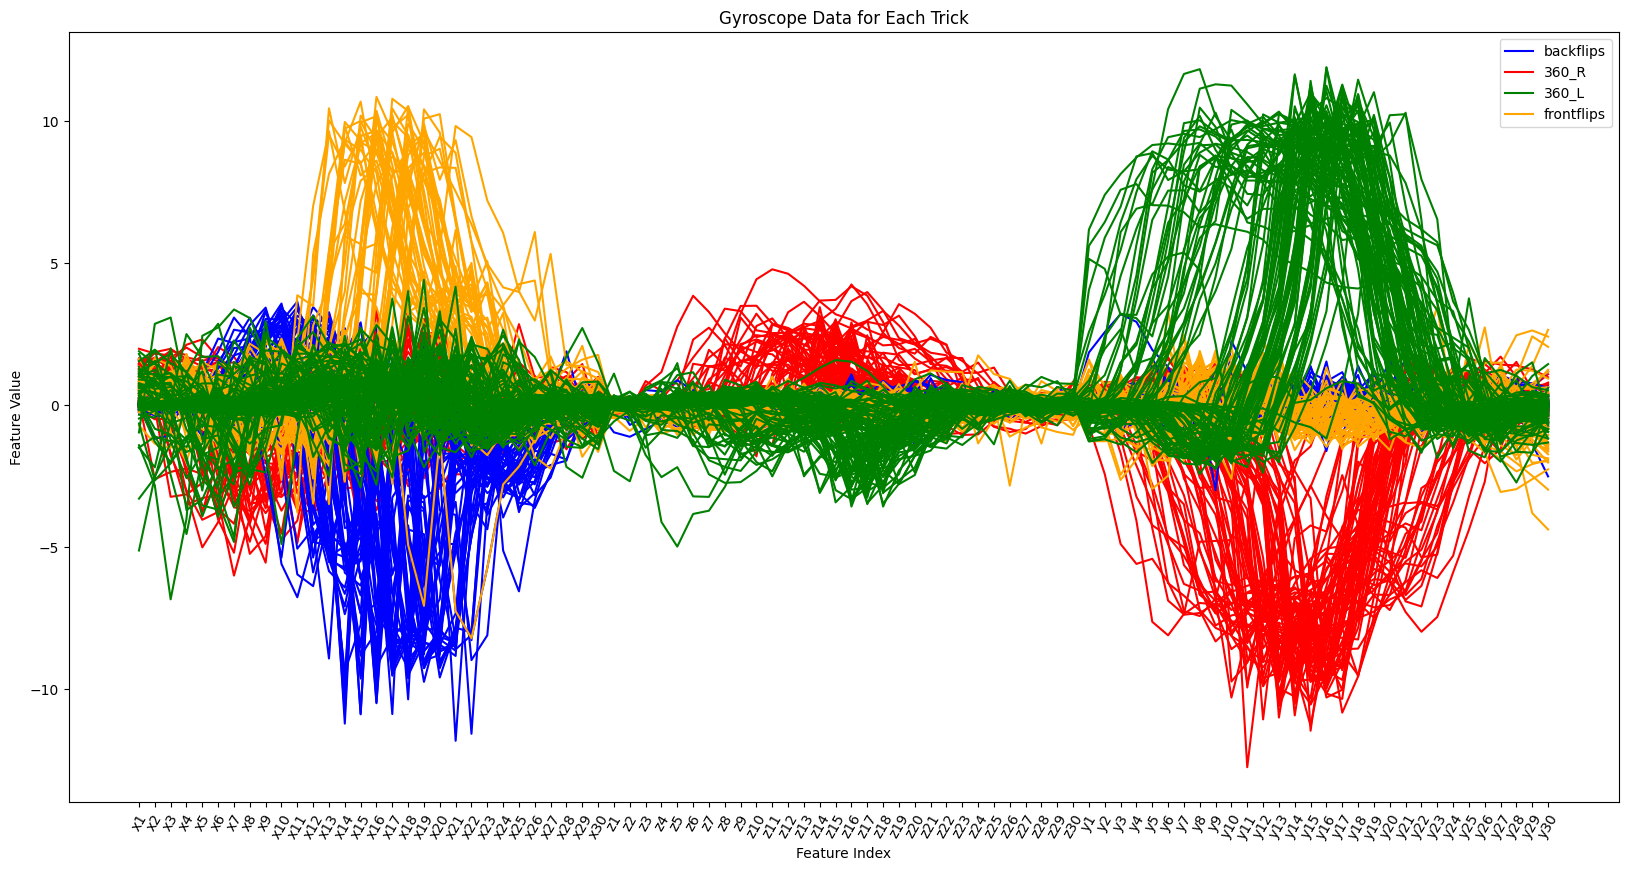

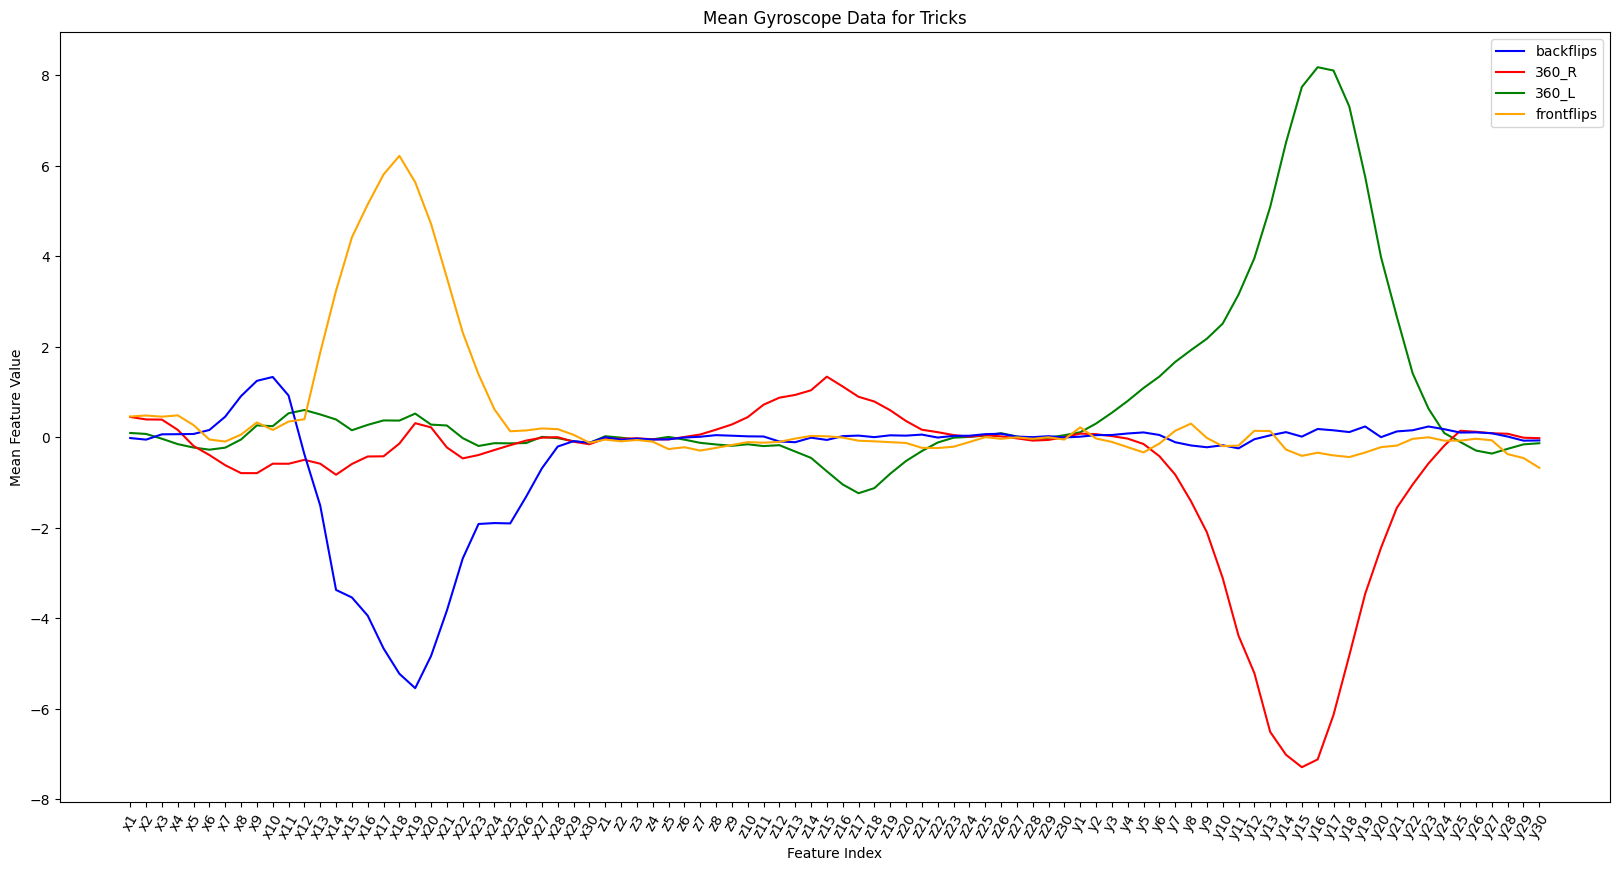

In [3]:
# Main function to handle data processing and plotting
def main():
    data_folder = 'GoPro_Data'
    current_dir = os.path.dirname(os.path.abspath('Load.ipynb'))
    unzip_file(data_folder, current_dir)
    
    master_folder_path = os.path.join(current_dir, data_folder)
    
    # Process master folder
    data = process_master_folder(master_folder_path)

    # Create DataFrame from the list of means
    columns = ['trick_name'] + [f'{col}{i + 1}' for col in ['x', 'z', 'y'] for i in range(30)]
    features_df = pd.DataFrame(data, columns=columns)

    # Save DataFrame to a CSV file and overwrite existing file
    features_df.to_csv('features_data.csv', index=False, mode='w')  # 'w' mode overwrites the file

    # Plot gyroscope data
    plot_data(features_df, plot_individual=True)
    plot_data(features_df, plot_individual=False)
    
if __name__ == "__main__":
    main()